In [ ]:
import jax
import jax.numpy as jnp
import pandas as pd
import numpy as np
import pandas as pd
import numpy as npnano
import numpyro.distributions as dist
import os 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import NMF
from optax import adam, exponential_decay
from numpyro.infer import SVI, TraceMeanField_ELBO
from jax import jit
from jax import random
from scipy import sparse
from numpyro import plate, sample, param
from numpyro.distributions import constraints
from tqdm import tqdm

In [2]:
print("Available devices:", jax.devices())

Available devices: [gpu(id=0)]


In [3]:
# Constants
orig = '../data/prepro/parlspeech-2018-2019/'
save = '../data/clean/parlspeech-2018-2019/'

In [4]:
# Load data
author_indices = jax.device_put(
    jnp.load(orig + "author_indices.npy"), jax.devices("gpu")[0]
)
counts = sparse.load_npz(orig + "counts.npz")

with open(orig + "vocabulary.txt",'r') as f:
    vocabulary=f.readlines()

with open(orig + "author_map.txt",'r') as f:
    author_map=f.readlines()

In [5]:
# Params
author_map = np.array(author_map)
num_authors = int(author_indices.max() + 1)
num_documents, num_words = counts.shape
pre_initialize_parameters = False
num_topics = 50
rng_seed = random.PRNGKey(0)
seed = 0
iter = 500
num_steps = 50000
batch_size = 512
lr = 0.01
decay = 0.01
print_steps = 10000
print_termi = True
words_per_topic = 10

In [6]:
if pre_initialize_parameters:
  nmf_model = NMF(
      n_components=num_topics,
      init='random',
      random_state=seed,
      max_iter=iter
  )
  initial_document_loc = jnp.log(
      jnp.array(np.float32(nmf_model.fit_transform(counts) + 1e-2))
  )
  initial_objective_topic_loc = jnp.log(
      jnp.array(np.float32(nmf_model.components_ + 1e-2))
  )
else:
  rng1, rng2 = random.split(rng_seed, 2)
  initial_document_loc = random.normal(
      rng1, shape = (num_documents, num_topics)
  )
  initial_objective_topic_loc = random.normal(
      rng2, shape =(num_topics, num_words)
  )

In [7]:
class TBIP:
    """Define the model and variational family"""
    def __init__(
        self, 
        N, 
        D, 
        K, 
        V, 
        batch_size, 
        init_mu_theta=None, 
        init_mu_beta=None
    ):
        self.N = N # number of people
        self.D = D # number of documents
        self.K = K # number of topics
        self.V = V # number of words in vocabulary
        self.batch_size = batch_size # number of documents in a batch

        if init_mu_theta is None:
            init_mu_theta = jnp.zeros([D, K])
        else:
            self.init_mu_theta = init_mu_theta

        if init_mu_beta is None:
            init_mu_beta = jnp.zeros([K, V])
        else:
            self.init_mu_beta = init_mu_beta

    def model(self, Y_batch, d_batch, i_batch):

        with plate("i", self.N):
            # Sample the per-unit latent variables (ideal points)
            x = sample("x", dist.Normal())

        with plate("k", size = self.K, dim = -2):
            with plate("k_v", size = self.V, dim = -1):
                beta = sample("beta", dist.Gamma(0.3, 0.3))
                eta = sample("eta", dist.Normal())

        with plate("d", size = self.D, subsample_size=self.batch_size, dim = -2):
            with plate("d_k", size = self.K, dim = -1):
                # Sample document-level latent variables (topic intensities)
                theta = sample("theta", dist.Gamma(0.3, 0.3))

            # Compute Poisson rates for each word
            P = jnp.sum(jnp.expand_dims(theta, 2) * jnp.expand_dims(beta, 0) *
                jnp.exp(jnp.expand_dims(x[i_batch], (1,2)) * jnp.expand_dims(eta, 0)), 1)

            with plate("v", size = self.V, dim = -1):
                # Sample observed words
                sample("Y_batch", dist.Poisson(P), obs = Y_batch)

    def guide(self, Y_batch, d_batch, i_batch):
        # This defines variational family. Notice that each of the latent variables
        # defined in the sample statements in the model above has a corresponding
        # sample statement in the guide. The guide is responsible for providing
        # variational parameters for each of these latent variables.

        # Also notice it is required that model and the guide have the same call
        mu_x = param("mu_x", init_value = -1  + 2 * random.uniform(random.PRNGKey(1), (self.N,)))
        sigma_x = param("sigma_y", init_value = jnp.ones([self.N]), constraint  = constraints.positive)

        mu_eta = param("mu_eta", init_value = random.normal(random.PRNGKey(2), (self.K,self.V)))
        sigma_eta = param("sigma_eta", init_value = jnp.ones([self.K,self.V]), constraint  = constraints.positive)

        mu_theta = param("mu_theta", init_value =  self.init_mu_theta)
        sigma_theta = param("sigma_theta", init_value =  jnp.ones([self.D, self.K]), constraint  = constraints.positive)

        mu_beta = param("mu_beta", init_value = self.init_mu_beta)
        sigma_beta = param("sigma_beta", init_value = jnp.ones([self.K, self.V]), constraint  = constraints.positive)

        with plate("i", self.N):
            sample("x", dist.Normal(mu_x, sigma_x))

        with plate("k", size = self.K, dim = -2):
            with plate("k_v", size = self.V, dim = -1):
                sample("beta", dist.LogNormal(mu_beta, sigma_beta))
                sample("eta", dist.Normal(mu_eta, sigma_eta))

        with plate("d", size = self.D, subsample_size=self.batch_size, dim = -2):
            with plate("d_k", size = self.K, dim = -1):
                sample("theta", dist.LogNormal(mu_theta[d_batch], sigma_theta[d_batch]))

    def get_batch(self, rng, Y, author_indices):
        # Helper functions to obtain a batch of data, convert from scipy.sparse to jax.numpy.array and move to gpu
        D_batch = jax.random.choice(rng, jnp.arange(self.D), shape = (self.batch_size,))
        Y_batch = jax.device_put(jnp.array(Y[D_batch].toarray()), jax.devices("gpu")[0])
        D_batch = jax.device_put(D_batch, jax.devices("gpu")[0])
        I_batch = author_indices[D_batch]
        return Y_batch, I_batch, D_batch

In [8]:
tbip = TBIP(
    N=num_authors,
    D=num_documents,
    K=num_topics,
    V=num_words,
    batch_size=batch_size,
    init_mu_theta=initial_document_loc,
    init_mu_beta=initial_objective_topic_loc
)

svi_batch = SVI(
    model=tbip.model,
    guide=tbip.guide,
    optim = adam(exponential_decay(lr, num_steps, decay)),
    loss = TraceMeanField_ELBO()
)

# Compile update function for faster training
svi_batch_update = jit(svi_batch.update)

# Get initial batch. This informs the dimension of arrays and ensures they are
# consistent with dimensions (N, D, K, V) defined above.
Y_batch, I_batch, D_batch = tbip.get_batch(
    random.PRNGKey(1), counts, author_indices
)

# Initialize the parameters using initial batch
svi_state = svi_batch.init(
    random.PRNGKey(0),
    Y_batch = Y_batch,
    d_batch = D_batch,
    i_batch = I_batch
)


In [9]:
def get_topics(
    neutral_mean,
    negative_mean,
    positive_mean,
    vocabulary,
    print_to_terminal=print_termi,
    words_per_topic=words_per_topic
):
  num_topics, num_words = neutral_mean.shape
  words_per_topic = words_per_topic
  top_neutral_words = np.argsort(-neutral_mean, axis=1)
  top_negative_words = np.argsort(-negative_mean, axis=1)
  top_positive_words = np.argsort(-positive_mean, axis=1)
  topic_strings = []
  for topic_idx in range(num_topics):
    neutral_start_string = "Neutral  {}:".format(topic_idx)
    neutral_row = [vocabulary[word] for word in
                    top_neutral_words[topic_idx, :words_per_topic]]
    neutral_row_string = ", ".join(neutral_row)
    neutral_string = " ".join([neutral_start_string, neutral_row_string])

    positive_start_string = "Positive {}:".format(topic_idx)
    positive_row = [vocabulary[word] for word in
                    top_positive_words[topic_idx, :words_per_topic]]
    positive_row_string = ", ".join(positive_row)
    positive_string = " ".join([positive_start_string, positive_row_string])

    negative_start_string = "Negative {}:".format(topic_idx)
    negative_row = [vocabulary[word] for word in
                    top_negative_words[topic_idx, :words_per_topic]]
    negative_row_string = ", ".join(negative_row)
    negative_string = " ".join([negative_start_string, negative_row_string])

    if print_to_terminal:
      topic_strings.append(negative_string)
      topic_strings.append(neutral_string)
      topic_strings.append(positive_string)
      topic_strings.append("==========")
    else:
      topic_strings.append("  \n".join(
        [negative_string, neutral_string, positive_string]))

  if print_to_terminal:
    all_topics = "{}\n".format(np.array(topic_strings))
  else:
    all_topics = np.array(topic_strings)
  return all_topics

In [10]:
# Run SVI
rngs = random.split(random.PRNGKey(2), num_steps)
losses = []
pbar = tqdm(range(num_steps))
for step in pbar:
    Y_batch, I_batch, D_batch = tbip.get_batch(rngs[step], counts, author_indices)
    svi_state, loss = svi_batch_update(svi_state,
        Y_batch = Y_batch,
        d_batch = D_batch,
        i_batch = I_batch)

    loss = loss/counts.shape[0]
    losses.append(loss)
    if step%print_steps == 0 or step == num_steps - 1:
        pbar.set_description("Init loss: " + "{:10.4f}".format(jnp.array(losses[0])) +
         "; Avg loss (last 100 iter): " + "{:10.4f}".format(jnp.array(losses[-100:]).mean()))

    if (step + 1) % 2500 == 0 or step == num_steps - 1:

        print(f"Results after {step} steps.")
        estimated_params = svi_batch.get_params(svi_state)

        neutral_mean = estimated_params["mu_beta"] + estimated_params["sigma_beta"]**2/2

        positive_mean = (estimated_params["mu_beta"] + estimated_params["mu_eta"] +
            (estimated_params["sigma_beta"]**2 + estimated_params["sigma_eta"]**2 )/2)

        negative_mean = (estimated_params["mu_beta"] - estimated_params["mu_eta"] +
            (estimated_params["sigma_beta"]**2 + estimated_params["sigma_eta"]**2 )/2)
        
        os.makedirs(save, exist_ok=True)
        np.save(f"{save}neutral_topic_mean.npy", neutral_mean)
        np.save(f"{save}negative_topic_mean.npy", positive_mean)
        np.save(f"{save}positive_topic_mean.npy", negative_mean)

        topics = get_topics(
            neutral_mean,
            positive_mean,
            negative_mean,
            vocabulary
        )

        with open(f"{save}topics.txt", 'w') as f:
            print(topics, file=f)
        print(topics)

        authors = pd.DataFrame({"name": author_map, "ideal_point" :  estimated_params["mu_x"]})
        authors.to_csv(f"{save}authors.csv")

        sorted_authors = "Authors sorted by their ideal points: " + \
          ",".join(list(authors.sort_values("ideal_point")["name"]))

        print(sorted_authors.replace("\n", " "))


Init loss: 1904651392.0000; Avg loss (last 100 iter): 1904651392.0000:   5%|▍         | 2496/50000 [00:54<16:36, 47.69it/s]

Results after 2499 steps.


/ext3/miniconda3/lib/python3.8/site-packages/jax/_src/numpy/lax_numpy.py:3652: UserWarning: 'kind' argument to argsort is ignored; only 'stable' sorts are supported.
  warnings.warn("'kind' argument to argsort is ignored; only 'stable' sorts "
Init loss: 1904651392.0000; Avg loss (last 100 iter): 1904651392.0000:   5%|▌         | 2506/50000 [00:56<1:13:15, 10.81it/s]

['Negative 0: friend confirm\n, japan\n, heard evidence\n, douglas ross\n, ministry housing communities\n, submissions\n, wave\n, government strategy\n, conditional\n, aids\n'
 'Neutral  0: douglas ross\n, merely\n, cases\n, playing\n, serious crime\n, worryingly\n, try ensure\n, wealthy\n, excellent job\n, ayr\n'
 'Positive 0: try ensure\n, woodford green duncan\n, important point\n, distant\n, nothing less\n, lothian martin whitfield\n, keep safe\n, merely\n, dublin\n, government commitment\n'
 '=========='
 'Negative 1: interests country\n, find way\n, indicative\n, former prime\n, linked\n, duration\n, indeed\n, intervened\n, bond\n, reminds\n'
 'Neutral  1: interests country\n, learn lessons\n, irish\n, ensure good\n, aware government\n, panels\n, dr wollaston\n, tracey\n, satisfy\n, magnitude\n'
 'Positive 1: sensibly\n, ensure good\n, tributes\n, learn lessons\n, showed\n, licences\n, government therefore\n, carolyn\n, criminal\n, irish\n'
 '=========='
 'Negative 2: friend dors

Init loss: 1904651392.0000; Avg loss (last 100 iter): 1904651392.0000:  10%|▉         | 4995/50000 [01:48<15:56, 47.07it/s]  

Results after 4999 steps.


Init loss: 1904651392.0000; Avg loss (last 100 iter): 1904651392.0000:  10%|█         | 5006/50000 [01:49<24:54, 30.11it/s]

['Negative 0: friend confirm\n, japan\n, heard evidence\n, douglas ross\n, government strategy\n, offering\n, submissions\n, throughout world\n, way government\n, bring together\n'
 'Neutral  0: douglas ross\n, cases\n, merely\n, try ensure\n, title\n, excellent job\n, playing\n, wealthy\n, heard evidence\n, decision\n'
 'Positive 0: try ensure\n, important point\n, woodford green duncan\n, distant\n, deposit\n, title\n, keep safe\n, nothing less\n, flight\n, introduced\n'
 '=========='
 'Negative 1: interests country\n, find way\n, indicative\n, indeed\n, linked\n, reminds\n, duration\n, former prime\n, bond\n, opposition front bench\n'
 'Neutral  1: interests country\n, irish\n, ensure good\n, learn lessons\n, aware government\n, find way\n, government therefore\n, satisfy\n, dr wollaston\n, panels\n'
 'Positive 1: ensure good\n, showed\n, government therefore\n, carolyn\n, tributes\n, sensibly\n, licences\n, criminal\n, forth\n, next week\n'
 '=========='
 'Negative 2: banbury victo

Init loss: 1904651392.0000; Avg loss (last 100 iter): 1904651392.0000:  15%|█▍        | 7496/50000 [02:41<14:53, 47.59it/s]

Results after 7499 steps.


Init loss: 1904651392.0000; Avg loss (last 100 iter): 1904651392.0000:  15%|█▌        | 7506/50000 [02:42<24:02, 29.46it/s]

['Negative 0: friend confirm\n, japan\n, heard evidence\n, douglas ross\n, government strategy\n, offering\n, way government\n, throughout world\n, outset\n, bring together\n'
 'Neutral  0: douglas ross\n, title\n, try ensure\n, cases\n, heard evidence\n, submissions\n, merely\n, excellent job\n, aids\n, wealthy\n'
 'Positive 0: try ensure\n, title\n, important point\n, flight\n, introduced\n, woodford green duncan\n, nothing less\n, keep safe\n, households\n, deposit\n'
 '=========='
 'Negative 1: interests country\n, find way\n, indicative\n, reminds\n, indeed\n, linked\n, former prime\n, opposition front bench\n, aware government\n, welsh government\n'
 'Neutral  1: interests country\n, ensure good\n, irish\n, aware government\n, find way\n, government therefore\n, learn lessons\n, satisfy\n, quicker\n, reminds\n'
 'Positive 1: ensure good\n, showed\n, government therefore\n, carolyn\n, licences\n, sensibly\n, tributes\n, criminal\n, forth\n, next week\n'
 '=========='
 'Negative 2:

Init loss: 1904651392.0000; Avg loss (last 100 iter): 1904651392.0000:  20%|█▉        | 9996/50000 [03:34<14:08, 47.16it/s]

Results after 9999 steps.
['Negative 0: friend confirm\n, japan\n, heard evidence\n, way government\n, offering\n, throughout world\n, outset\n, government strategy\n, bring together\n, integral\n'
 'Neutral  0: douglas ross\n, title\n, heard evidence\n, try ensure\n, submissions\n, outset\n, israeli\n, friend confirm\n, throughout world\n, breach\n'
 'Positive 0: important point\n, title\n, try ensure\n, households\n, flight\n, introduced\n, deposit\n, dublin\n, prohibited\n, nothing less\n'
 '=========='
 'Negative 1: interests country\n, find way\n, indicative\n, reminds\n, opposition front bench\n, indeed\n, former prime\n, linked\n, welsh government\n, aware government\n'
 'Neutral  1: interests country\n, ensure good\n, find way\n, aware government\n, irish\n, reminds\n, government therefore\n, quicker\n, forth\n, satisfy\n'
 'Positive 1: ensure good\n, sensibly\n, showed\n, licences\n, carolyn\n, forth\n, next week\n, passion\n, government therefore\n, driver\n'
 '=========='
 '

Init loss: 1904651392.0000; Avg loss (last 100 iter): 43914.1484:  25%|██▍       | 12497/50000 [04:27<13:07, 47.61it/s]    

Results after 12499 steps.


Init loss: 1904651392.0000; Avg loss (last 100 iter): 43914.1484:  25%|██▌       | 12507/50000 [04:28<21:24, 29.19it/s]

['Negative 0: japan\n, friend confirm\n, heard evidence\n, way government\n, offering\n, outset\n, government strategy\n, throughout world\n, integral\n, bring together\n'
 'Neutral  0: title\n, heard evidence\n, douglas ross\n, outset\n, israeli\n, breach\n, throughout world\n, blank\n, friend confirm\n, submissions\n'
 'Positive 0: households\n, deposit\n, dublin\n, distant\n, nothing less\n, prohibited\n, flight\n, important point\n, committing\n, introduced\n'
 '=========='
 'Negative 1: interests country\n, find way\n, reminds\n, indicative\n, opposition front bench\n, welsh government\n, indeed\n, former prime\n, bond\n, linked\n'
 'Neutral  1: interests country\n, ensure good\n, find way\n, reminds\n, government therefore\n, forth\n, aware government\n, quicker\n, passion\n, carolyn\n'
 'Positive 1: ensure good\n, sensibly\n, carolyn\n, licences\n, showed\n, forth\n, government therefore\n, passion\n, next week\n, driver\n'
 '=========='
 'Negative 2: banbury victoria prentis\n,

Init loss: 1904651392.0000; Avg loss (last 100 iter): 43914.1484:  30%|██▉       | 14997/50000 [05:20<12:23, 47.07it/s]

Results after 14999 steps.


Init loss: 1904651392.0000; Avg loss (last 100 iter): 43914.1484:  30%|███       | 15007/50000 [05:20<19:57, 29.23it/s]

['Negative 0: japan\n, friend confirm\n, way government\n, heard evidence\n, offering\n, government strategy\n, integral\n, outset\n, throughout world\n, advisers\n'
 'Neutral  0: title\n, heard evidence\n, outset\n, breach\n, blank\n, israeli\n, throughout world\n, way government\n, friend confirm\n, government strategy\n'
 'Positive 0: dublin\n, households\n, deposit\n, distant\n, committing\n, nothing less\n, prohibited\n, important point\n, flight\n, introduced\n'
 '=========='
 'Negative 1: find way\n, interests country\n, reminds\n, indicative\n, opposition front bench\n, welsh government\n, indeed\n, bond\n, former prime\n, linked\n'
 'Neutral  1: interests country\n, ensure good\n, find way\n, reminds\n, government therefore\n, forth\n, quicker\n, passion\n, carolyn\n, aware government\n'
 'Positive 1: ensure good\n, sensibly\n, licences\n, showed\n, forth\n, carolyn\n, government therefore\n, passion\n, driver\n, next week\n'
 '=========='
 'Negative 2: government country\n, b

Init loss: 1904651392.0000; Avg loss (last 100 iter): 43914.1484:  35%|███▍      | 17497/50000 [06:13<11:16, 48.07it/s]

Results after 17499 steps.


Init loss: 1904651392.0000; Avg loss (last 100 iter): 43914.1484:  35%|███▌      | 17507/50000 [06:13<18:31, 29.23it/s]

['Negative 0: japan\n, friend confirm\n, way government\n, heard evidence\n, offering\n, integral\n, government strategy\n, outset\n, advisers\n, throughout world\n'
 'Neutral  0: heard evidence\n, blank\n, outset\n, title\n, breach\n, way government\n, government strategy\n, israeli\n, friend confirm\n, throughout world\n'
 'Positive 0: dublin\n, deposit\n, households\n, distant\n, committing\n, islamophobia\n, nothing less\n, prohibited\n, important point\n, introduced\n'
 '=========='
 'Negative 1: find way\n, reminds\n, indicative\n, interests country\n, opposition front bench\n, welsh government\n, indeed\n, bond\n, former prime\n, sectors\n'
 'Neutral  1: interests country\n, ensure good\n, reminds\n, find way\n, government therefore\n, forth\n, passion\n, carolyn\n, sensibly\n, infection\n'
 'Positive 1: ensure good\n, sensibly\n, forth\n, showed\n, licences\n, government therefore\n, carolyn\n, driver\n, passion\n, next week\n'
 '=========='
 'Negative 2: banbury victoria prent

Init loss: 1904651392.0000; Avg loss (last 100 iter): 43914.1484:  40%|███▉      | 19997/50000 [07:06<10:27, 47.83it/s]

Results after 19999 steps.


Init loss: 1904651392.0000; Avg loss (last 100 iter):  3430.9912:  40%|████      | 20007/50000 [07:06<17:36, 28.38it/s]

['Negative 0: japan\n, way government\n, friend confirm\n, integral\n, offering\n, heard evidence\n, government strategy\n, advisers\n, outset\n, trans pennine\n'
 'Neutral  0: blank\n, heard evidence\n, way government\n, outset\n, government strategy\n, japan\n, breach\n, title\n, dublin\n, friend confirm\n'
 'Positive 0: islamophobia\n, dublin\n, deposit\n, committing\n, distant\n, households\n, nothing less\n, prohibited\n, important point\n, gates\n'
 '=========='
 'Negative 1: reminds\n, find way\n, indicative\n, opposition front bench\n, welsh government\n, bond\n, interests country\n, indeed\n, sectors\n, former prime\n'
 'Neutral  1: reminds\n, interests country\n, find way\n, ensure good\n, government therefore\n, forth\n, welsh government\n, infection\n, sensibly\n, passion\n'
 'Positive 1: sensibly\n, ensure good\n, showed\n, licences\n, forth\n, government therefore\n, driver\n, carolyn\n, government act\n, passion\n'
 '=========='
 'Negative 2: banbury victoria prentis\n, 

Init loss: 1904651392.0000; Avg loss (last 100 iter):  3430.9912:  45%|████▍     | 22497/50000 [07:59<09:33, 47.93it/s]

Results after 22499 steps.


Init loss: 1904651392.0000; Avg loss (last 100 iter):  3430.9912:  45%|████▌     | 22507/50000 [07:59<15:43, 29.14it/s]

['Negative 0: japan\n, way government\n, integral\n, offering\n, trans pennine\n, friend confirm\n, heard evidence\n, advisers\n, government strategy\n, outset\n'
 'Neutral  0: way government\n, blank\n, heard evidence\n, japan\n, outset\n, government strategy\n, integral\n, trans pennine\n, advisers\n, dublin\n'
 'Positive 0: islamophobia\n, deposit\n, dublin\n, committing\n, distant\n, households\n, nothing less\n, prohibited\n, leaving deal\n, gates\n'
 '=========='
 'Negative 1: reminds\n, indicative\n, find way\n, welsh government\n, opposition front bench\n, bond\n, indeed\n, interests country\n, sectors\n, amazed\n'
 'Neutral  1: reminds\n, find way\n, ensure good\n, interests country\n, welsh government\n, government therefore\n, infection\n, forth\n, indicative\n, sensibly\n'
 'Positive 1: sensibly\n, ensure good\n, showed\n, licences\n, driver\n, forth\n, carolyn\n, government therefore\n, condition\n, government act\n'
 '=========='
 'Negative 2: banbury victoria prentis\n, 

Init loss: 1904651392.0000; Avg loss (last 100 iter):  3430.9912:  50%|████▉     | 24997/50000 [08:51<08:44, 47.64it/s]

Results after 24999 steps.


Init loss: 1904651392.0000; Avg loss (last 100 iter):  3430.9912:  50%|█████     | 25007/50000 [08:52<14:18, 29.13it/s]

['Negative 0: japan\n, way government\n, trans pennine\n, integral\n, offering\n, friend confirm\n, heard evidence\n, advisers\n, proper scrutiny\n, government strategy\n'
 'Neutral  0: way government\n, japan\n, blank\n, trans pennine\n, heard evidence\n, integral\n, islamophobia\n, government strategy\n, advisers\n, outset\n'
 'Positive 0: islamophobia\n, deposit\n, committing\n, dublin\n, distant\n, households\n, nothing less\n, prohibited\n, leaving deal\n, gates\n'
 '=========='
 'Negative 1: reminds\n, indicative\n, find way\n, welsh government\n, opposition front bench\n, bond\n, indeed\n, interests country\n, infection\n, amazed\n'
 'Neutral  1: reminds\n, find way\n, welsh government\n, ensure good\n, indicative\n, infection\n, interests country\n, opposition front bench\n, forth\n, sensibly\n'
 'Positive 1: sensibly\n, showed\n, ensure good\n, licences\n, driver\n, carolyn\n, forth\n, condition\n, government therefore\n, government act\n'
 '=========='
 'Negative 2: banbury v

Init loss: 1904651392.0000; Avg loss (last 100 iter):  3430.9912:  55%|█████▍    | 27497/50000 [09:44<07:47, 48.10it/s]

Results after 27499 steps.


Init loss: 1904651392.0000; Avg loss (last 100 iter):  3430.9912:  55%|█████▌    | 27507/50000 [09:45<12:42, 29.50it/s]

['Negative 0: japan\n, trans pennine\n, way government\n, integral\n, proper scrutiny\n, offering\n, advisers\n, heard evidence\n, friend confirm\n, government strategy\n'
 'Neutral  0: way government\n, trans pennine\n, japan\n, islamophobia\n, blank\n, heard evidence\n, integral\n, advisers\n, government strategy\n, committing\n'
 'Positive 0: islamophobia\n, deposit\n, nothing less\n, committing\n, distant\n, dublin\n, households\n, prohibited\n, leaving deal\n, gates\n'
 '=========='
 'Negative 1: indicative\n, reminds\n, welsh government\n, opposition front bench\n, find way\n, bond\n, indeed\n, number\n, sectors\n, amazed\n'
 'Neutral  1: reminds\n, indicative\n, find way\n, welsh government\n, opposition front bench\n, ensure good\n, infection\n, carolyn\n, sensibly\n, forth\n'
 'Positive 1: sensibly\n, showed\n, driver\n, condition\n, licences\n, carolyn\n, ensure good\n, forth\n, inclusive\n, government therefore\n'
 '=========='
 'Negative 2: new zealand\n, banbury victoria p

Init loss: 1904651392.0000; Avg loss (last 100 iter):  3430.9912:  60%|█████▉    | 29997/50000 [10:37<06:58, 47.78it/s]

Results after 29999 steps.


Init loss: 1904651392.0000; Avg loss (last 100 iter):   843.8508:  60%|██████    | 30007/50000 [10:38<11:39, 28.57it/s]

['Negative 0: japan\n, trans pennine\n, way government\n, proper scrutiny\n, integral\n, offering\n, advisers\n, heard evidence\n, friend confirm\n, breast cancer\n'
 'Neutral  0: islamophobia\n, trans pennine\n, japan\n, way government\n, integral\n, heard evidence\n, proper scrutiny\n, advisers\n, deposit\n, blank\n'
 'Positive 0: islamophobia\n, deposit\n, nothing less\n, distant\n, committing\n, dublin\n, households\n, introduced\n, prohibited\n, leaving deal\n'
 '=========='
 'Negative 1: indicative\n, reminds\n, opposition front bench\n, welsh government\n, bond\n, find way\n, indeed\n, number\n, sectors\n, amazed\n'
 'Neutral  1: reminds\n, indicative\n, welsh government\n, find way\n, opposition front bench\n, infection\n, ensure good\n, sensibly\n, carolyn\n, forth\n'
 'Positive 1: showed\n, sensibly\n, condition\n, driver\n, licences\n, carolyn\n, inclusive\n, ensure good\n, assure\n, forth\n'
 '=========='
 'Negative 2: new zealand\n, banbury victoria prentis\n, government c

Init loss: 1904651392.0000; Avg loss (last 100 iter):   843.8508:  65%|██████▍   | 32497/50000 [11:30<06:09, 47.40it/s]

Results after 32499 steps.


Init loss: 1904651392.0000; Avg loss (last 100 iter):   843.8508:  65%|██████▌   | 32507/50000 [11:30<09:55, 29.38it/s]

['Negative 0: japan\n, trans pennine\n, proper scrutiny\n, way government\n, integral\n, breast cancer\n, offering\n, advisers\n, heard evidence\n, friend confirm\n'
 'Neutral  0: islamophobia\n, trans pennine\n, japan\n, way government\n, integral\n, deposit\n, nothing less\n, proper scrutiny\n, advisers\n, heard evidence\n'
 'Positive 0: islamophobia\n, deposit\n, nothing less\n, distant\n, committing\n, households\n, dublin\n, introduced\n, dame judith\n, prohibited\n'
 '=========='
 'Negative 1: indicative\n, reminds\n, opposition front bench\n, bond\n, welsh government\n, find way\n, indeed\n, number\n, sectors\n, content\n'
 'Neutral  1: reminds\n, indicative\n, opposition front bench\n, welsh government\n, find way\n, infection\n, ensure good\n, carolyn\n, sensibly\n, bond\n'
 'Positive 1: showed\n, condition\n, sensibly\n, driver\n, assure\n, inclusive\n, carolyn\n, licences\n, ensure good\n, forth\n'
 '=========='
 'Negative 2: new zealand\n, banbury victoria prentis\n, cold\n

Init loss: 1904651392.0000; Avg loss (last 100 iter):   843.8508:  70%|██████▉   | 34997/50000 [12:23<05:16, 47.47it/s]

Results after 34999 steps.


Init loss: 1904651392.0000; Avg loss (last 100 iter):   843.8508:  70%|███████   | 35007/50000 [12:23<08:36, 29.02it/s]

['Negative 0: trans pennine\n, japan\n, proper scrutiny\n, way government\n, integral\n, breast cancer\n, offering\n, advisers\n, heard evidence\n, liz\n'
 'Neutral  0: islamophobia\n, trans pennine\n, japan\n, way government\n, deposit\n, nothing less\n, integral\n, proper scrutiny\n, dame judith\n, advisers\n'
 'Positive 0: islamophobia\n, deposit\n, nothing less\n, distant\n, households\n, committing\n, introduced\n, dublin\n, dame judith\n, prohibited\n'
 '=========='
 'Negative 1: indicative\n, reminds\n, opposition front bench\n, bond\n, welsh government\n, indeed\n, find way\n, number\n, sectors\n, content\n'
 'Neutral  1: reminds\n, indicative\n, opposition front bench\n, welsh government\n, find way\n, indeed\n, bond\n, condition\n, infection\n, sensibly\n'
 'Positive 1: showed\n, condition\n, sensibly\n, assure\n, driver\n, inclusive\n, carolyn\n, licences\n, ensure good\n, forth\n'
 '=========='
 'Negative 2: new zealand\n, banbury victoria prentis\n, cold\n, merits\n, gover

Init loss: 1904651392.0000; Avg loss (last 100 iter):   843.8508:  75%|███████▍  | 37497/50000 [13:15<04:13, 49.35it/s]

Results after 37499 steps.


Init loss: 1904651392.0000; Avg loss (last 100 iter):   843.8508:  75%|███████▌  | 37507/50000 [13:15<06:57, 29.96it/s]

['Negative 0: trans pennine\n, japan\n, proper scrutiny\n, way government\n, breast cancer\n, integral\n, offering\n, advisers\n, liz\n, heard evidence\n'
 'Neutral  0: islamophobia\n, trans pennine\n, japan\n, deposit\n, way government\n, nothing less\n, proper scrutiny\n, integral\n, dame judith\n, introduced\n'
 'Positive 0: islamophobia\n, deposit\n, nothing less\n, households\n, distant\n, introduced\n, committing\n, dame judith\n, dublin\n, important point\n'
 '=========='
 'Negative 1: indicative\n, reminds\n, opposition front bench\n, bond\n, welsh government\n, indeed\n, find way\n, number\n, sectors\n, information\n'
 'Neutral  1: indicative\n, reminds\n, opposition front bench\n, welsh government\n, find way\n, indeed\n, bond\n, condition\n, showed\n, sectors\n'
 'Positive 1: showed\n, condition\n, assure\n, sensibly\n, driver\n, inclusive\n, licences\n, carolyn\n, ensure good\n, forth\n'
 '=========='
 'Negative 2: new zealand\n, cold\n, banbury victoria prentis\n, merits\n

Init loss: 1904651392.0000; Avg loss (last 100 iter):   843.8508:  80%|███████▉  | 39997/50000 [14:07<03:27, 48.12it/s]

Results after 39999 steps.


Init loss: 1904651392.0000; Avg loss (last 100 iter):   460.3260:  80%|████████  | 40007/50000 [14:08<05:52, 28.35it/s]

['Negative 0: trans pennine\n, japan\n, proper scrutiny\n, breast cancer\n, way government\n, integral\n, offering\n, advisers\n, passengers\n, liz\n'
 'Neutral  0: islamophobia\n, trans pennine\n, japan\n, deposit\n, way government\n, nothing less\n, children\n, proper scrutiny\n, integral\n, country\n'
 'Positive 0: islamophobia\n, deposit\n, nothing less\n, introduced\n, households\n, distant\n, committing\n, dame judith\n, dublin\n, important point\n'
 '=========='
 'Negative 1: indicative\n, reminds\n, opposition front bench\n, bond\n, indeed\n, welsh government\n, number\n, find way\n, information\n, sectors\n'
 'Neutral  1: indicative\n, reminds\n, opposition front bench\n, welsh government\n, indeed\n, find way\n, condition\n, bond\n, showed\n, sectors\n'
 'Positive 1: showed\n, condition\n, assure\n, driver\n, sensibly\n, inclusive\n, licences\n, carolyn\n, reminds\n, forth\n'
 '=========='
 'Negative 2: new zealand\n, cold\n, banbury victoria prentis\n, merits\n, government c

Init loss: 1904651392.0000; Avg loss (last 100 iter):   460.3260:  85%|████████▍ | 42497/50000 [15:00<02:35, 48.14it/s]

Results after 42499 steps.


Init loss: 1904651392.0000; Avg loss (last 100 iter):   460.3260:  85%|████████▌ | 42507/50000 [15:00<04:13, 29.58it/s]

['Negative 0: trans pennine\n, japan\n, breast cancer\n, proper scrutiny\n, way government\n, integral\n, offering\n, passengers\n, advisers\n, liz\n'
 'Neutral  0: islamophobia\n, trans pennine\n, japan\n, children\n, country\n, deposit\n, education\n, introduced\n, way government\n, new\n'
 'Positive 0: islamophobia\n, deposit\n, nothing less\n, introduced\n, households\n, distant\n, immigration\n, dame judith\n, committing\n, important point\n'
 '=========='
 'Negative 1: indicative\n, reminds\n, opposition front bench\n, bond\n, indeed\n, welsh government\n, number\n, find way\n, information\n, sectors\n'
 'Neutral  1: indicative\n, reminds\n, opposition front bench\n, welsh government\n, indeed\n, condition\n, find way\n, bond\n, number\n, sectors\n'
 'Positive 1: condition\n, showed\n, assure\n, driver\n, inclusive\n, sensibly\n, licences\n, carolyn\n, reminds\n, next week\n'
 '=========='
 'Negative 2: new zealand\n, cold\n, banbury victoria prentis\n, merits\n, number important

Init loss: 1904651392.0000; Avg loss (last 100 iter):   460.3260:  90%|████████▉ | 44997/50000 [15:52<01:45, 47.51it/s]

Results after 44999 steps.


Init loss: 1904651392.0000; Avg loss (last 100 iter):   460.3260:  90%|█████████ | 45007/50000 [15:53<02:51, 29.19it/s]

['Negative 0: trans pennine\n, japan\n, breast cancer\n, proper scrutiny\n, integral\n, way government\n, offering\n, passengers\n, particular\n, liz\n'
 'Neutral  0: islamophobia\n, trans pennine\n, children\n, country\n, education\n, japan\n, introduced\n, particular\n, new\n, community\n'
 'Positive 0: islamophobia\n, deposit\n, nothing less\n, introduced\n, households\n, immigration\n, children\n, important point\n, distant\n, country\n'
 '=========='
 'Negative 1: indicative\n, reminds\n, opposition front bench\n, bond\n, indeed\n, welsh government\n, number\n, find way\n, information\n, sectors\n'
 'Neutral  1: indicative\n, reminds\n, opposition front bench\n, welsh government\n, indeed\n, condition\n, find way\n, number\n, court\n, sectors\n'
 'Positive 1: condition\n, showed\n, assure\n, driver\n, inclusive\n, sensibly\n, licences\n, next week\n, reminds\n, passion\n'
 '=========='
 'Negative 2: new zealand\n, cold\n, banbury victoria prentis\n, merits\n, number important\n, s

Init loss: 1904651392.0000; Avg loss (last 100 iter):   460.3260:  95%|█████████▍| 47497/50000 [16:45<00:52, 47.30it/s]

Results after 47499 steps.


Init loss: 1904651392.0000; Avg loss (last 100 iter):   460.3260:  95%|█████████▌| 47507/50000 [16:46<01:24, 29.39it/s]

['Negative 0: trans pennine\n, japan\n, breast cancer\n, proper scrutiny\n, integral\n, way government\n, offering\n, passengers\n, particular\n, advisers\n'
 'Neutral  0: islamophobia\n, children\n, country\n, education\n, trans pennine\n, particular\n, introduced\n, new\n, community\n, japan\n'
 'Positive 0: islamophobia\n, deposit\n, nothing less\n, introduced\n, households\n, immigration\n, children\n, country\n, important point\n, community\n'
 '=========='
 'Negative 1: indicative\n, reminds\n, opposition front bench\n, indeed\n, bond\n, number\n, welsh government\n, information\n, find way\n, sectors\n'
 'Neutral  1: indicative\n, reminds\n, opposition front bench\n, indeed\n, welsh government\n, condition\n, court\n, deal\n, ensure\n, number\n'
 'Positive 1: condition\n, showed\n, assure\n, driver\n, inclusive\n, licences\n, sensibly\n, next week\n, reminds\n, passion\n'
 '=========='
 'Negative 2: new zealand\n, cold\n, merits\n, banbury victoria prentis\n, separated\n, number

Init loss: 1904651392.0000; Avg loss (last 100 iter):   429.9193: 100%|█████████▉| 49997/50000 [17:38<00:00, 47.62it/s]

Results after 49999 steps.


Init loss: 1904651392.0000; Avg loss (last 100 iter):   429.9193: 100%|██████████| 50000/50000 [17:38<00:00, 47.22it/s]

['Negative 0: trans pennine\n, japan\n, breast cancer\n, proper scrutiny\n, passengers\n, integral\n, offering\n, particular\n, way government\n, education\n'
 'Neutral  0: islamophobia\n, children\n, country\n, education\n, particular\n, introduced\n, new\n, community\n, ensure\n, number\n'
 'Positive 0: islamophobia\n, deposit\n, introduced\n, households\n, nothing less\n, immigration\n, children\n, country\n, important point\n, community\n'
 '=========='
 'Negative 1: indicative\n, reminds\n, opposition front bench\n, indeed\n, bond\n, number\n, welsh government\n, information\n, find way\n, sectors\n'
 'Neutral  1: indicative\n, reminds\n, opposition front bench\n, indeed\n, condition\n, welsh government\n, deal\n, ensure\n, court\n, number\n'
 'Positive 1: condition\n, showed\n, assure\n, driver\n, inclusive\n, licences\n, next week\n, criminal\n, sensibly\n, passion\n'
 '=========='
 'Negative 2: new zealand\n, cold\n, merits\n, banbury victoria prentis\n, separated\n, number imp

In [12]:
# Load Results
neutral_topic_mean = np.load(f"{save}neutral_topic_mean.npy")
negative_topic_mean = np.load(f"{save}negative_topic_mean.npy")
positive_topic_mean = np.load(f"{save}positive_topic_mean.npy")
authors = pd.read_csv(f"{save}authors.csv")
authors["name"] = authors["name"].str.replace("\n", "")

In [13]:
selected_authors = np.array(
    ["Jo Swinson (Libdem)", "Tim Farron (Libdem)",
     "Jeremy Corbyn (Lab)", "Keir Starmer (Lab)",
     "Boris Johnson (Con)", "Rishi Sunak (Con)",
     "Sylvia Eileen Paisley (Independent)", "Stephen Lloyd (Independent)"]
)

[]

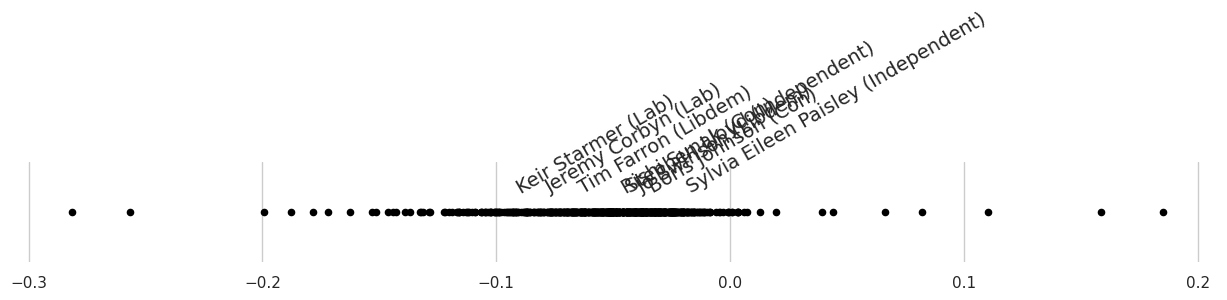

In [14]:
sns.set(style="whitegrid")
fig = plt.figure(figsize=(12, 1))
ax = plt.axes([0, 0, 1, 1], frameon=False)
for index in range(authors.shape[0]):
  ax.scatter(authors["ideal_point"][index], 0, c='black', s=20)
  if authors["name"][index] in selected_authors:
      ax.annotate(
          author_map[index],
          xy=(authors["ideal_point"][index], 0.),
          xytext=(authors["ideal_point"][index], 0), rotation=30, size=14
      )
ax.set_yticks([])

In [15]:
authors_by_party = authors.copy()
authors_by_party[['name_only', 'party_only']] = authors_by_party['name'].str.split('(', n=1, expand=True)
authors_by_party['name_only'] = authors_by_party['name_only'].map(lambda x: x.rstrip(' '))
authors_by_party['party_only'] = authors_by_party['party_only'].map(lambda x: x.rstrip(')'))

In [16]:
authors_by_party.groupby('party_only')['ideal_point'].mean()

party_only
Change Uk     -0.045406
Con           -0.045661
Dup           -0.049067
Gpew          -0.048789
Independent   -0.037446
Lab           -0.056699
Libdem        -0.060410
Plaidcymru    -0.077989
Snp           -0.069938
Name: ideal_point, dtype: float64

In [17]:
authors_by_party.groupby('party_only')['ideal_point'].min()

party_only
Change Uk     -0.076092
Con           -0.256566
Dup           -0.085646
Gpew          -0.048789
Independent   -0.067218
Lab           -0.281394
Libdem        -0.171858
Plaidcymru    -0.102734
Snp           -0.153092
Name: ideal_point, dtype: float64

In [18]:
authors_by_party.groupby('party_only')['ideal_point'].max()

party_only
Change Uk     -0.017650
Con            0.110132
Dup           -0.021337
Gpew          -0.048789
Independent   -0.015889
Lab            0.185070
Libdem        -0.018163
Plaidcymru    -0.054753
Snp           -0.018374
Name: ideal_point, dtype: float64

In [19]:
authors_by_party.groupby('party_only')['ideal_point'].median()

party_only
Change Uk     -0.043940
Con           -0.040088
Dup           -0.046769
Gpew          -0.048789
Independent   -0.045897
Lab           -0.052301
Libdem        -0.046690
Plaidcymru    -0.077234
Snp           -0.070312
Name: ideal_point, dtype: float64

In [20]:
authors_by_party

,Unnamed: 0,name,ideal_point,name_only,party_only
0,0,Adam Afriyie (Con),-0.029925,Adam Afriyie,Con
1,1,Adam Holloway (Con),0.019495,Adam Holloway,Con
2,2,Adrian Bailey (Lab),-0.031332,Adrian Bailey,Lab
3,3,Afzal Khan (Lab),-0.076866,Afzal Khan,Lab
4,4,Alan Brown (Snp),-0.051520,Alan Brown,Snp
...,...,...,...,...,...
624,624,William Wragg (Con),-0.056383,William Wragg,Con
625,625,Yasmin Qureshi (Lab),-0.037337,Yasmin Qureshi,Lab
626,626,Yvette Cooper (Lab),-0.050094,Yvette Cooper,Lab
627,627,Yvonne Fovargue (Lab),-0.046906,Yvonne Fovargue,Lab


In [ ]:
print(topics)